<a href="https://www.kaggle.com/code/skanderadamafi/text-to-image-cgan-generator?scriptVersionId=294843864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **1. Dataset Setup:**

In [1]:
# Import libraries
import pandas as pd

# File paths
classes_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/classes.txt'
images_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/images.txt'
train_test_split_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/train_test_split.txt'
image_class_labels_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/image_class_labels.txt'
bounding_boxes_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/bounding_boxes.txt'

# Load metadata
classes = pd.read_csv(classes_path, sep=' ', header=None, names=['ClassID', 'ClassName'])
images = pd.read_csv(images_path, sep=' ', header=None, names=['ImageID', 'FilePath'])
train_test_split = pd.read_csv(train_test_split_path, sep=' ', header=None, names=['ImageID', 'IsTrainingImage'])
image_class_labels = pd.read_csv(image_class_labels_path, sep=' ', header=None, names=['ImageID', 'ClassID'])
bounding_boxes = pd.read_csv(bounding_boxes_path, sep=' ', header=None, names=['ImageID', 'x_min', 'y_min', 'width', 'height'])

# Merge all metadata
metadata = images.merge(image_class_labels, on='ImageID') \
                 .merge(train_test_split, on='ImageID') \
                 .merge(classes, on='ClassID') \
                 .merge(bounding_boxes, on='ImageID')

# Display the first few rows of the updated metadata
metadata.head()


,ImageID,FilePath,ClassID,IsTrainingImage,ClassName,x_min,y_min,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross,60.0,27.0,325.0,304.0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139.0,30.0,153.0,264.0
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross,14.0,112.0,388.0,186.0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112.0,90.0,255.0,242.0
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70.0,50.0,134.0,303.0


# **2. Data Preprocessing**

In [2]:
from transformers import BertTokenizer, BertModel
import torch

2026-01-29 22:24:58.475892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769725498.697415      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769725498.760197      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769725499.270930      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769725499.270980      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769725499.270983      23 computation_placer.cc:177] computation placer alr

In [3]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# Example textual descriptions
descriptions = [
    "The Laysan Albatross is a large seabird.",
    "This bird has white feathers and black wings.",
    "It is commonly found on islands in the North Pacific."
]

# Tokenize and encode
encoded_inputs = tokenizer(
    descriptions,
    padding=True,       # Pad to the longest sequence
    truncation=True,    # Truncate to the maximum length
    max_length=128,     # Max token length
    return_tensors='pt' # Return PyTorch tensors
)

In [5]:
# Get BERT embeddings
with torch.no_grad():
    outputs = bert_model(**encoded_inputs)

# Extract the last hidden states
last_hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

# Example: Use the CLS token embedding (first token) for sentence-level embeddings
cls_embeddings = last_hidden_states[:, 0, :]  # Shape: (batch_size, hidden_size)

In [6]:
import os
import numpy as np
from PIL import Image

def preprocess_images(image_dir, target_size=(64, 64)):
    images = []
    
    # Iterate through the directory and subdirectories
    for root, dirs, files in os.walk(image_dir):
        # Only process files in the image directories (skip if root is the main image_dir)
        if root == image_dir: 
            continue  # Skip the root folder itself

        for filename in files:
            print(f"Found file: {filename}")  # Debugging line to check the files
            
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, filename)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                    img_array = np.array(img_resized) / 255.0
                    images.append(img_array)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
    
    if len(images) == 0:
        raise ValueError(f"No images were found or processed in {image_dir}.")
    
    return np.array(images)

# Example usage
image_file_path = '/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/images/'
images = preprocess_images(image_file_path)
print(f"Loaded {len(images)} images.")

Found file: Acadian_Flycatcher_0041_795605.jpg
Found file: Acadian_Flycatcher_0066_29190.jpg
Found file: Acadian_Flycatcher_0052_795610.jpg
Found file: Acadian_Flycatcher_0008_795599.jpg
Found file: Acadian_Flycatcher_0058_795602.jpg
Found file: Acadian_Flycatcher_0005_29157.jpg
Found file: Acadian_Flycatcher_0043_29115.jpg
Found file: Acadian_Flycatcher_0070_29150.jpg
Found file: Acadian_Flycatcher_0044_795624.jpg
Found file: Acadian_Flycatcher_0012_795612.jpg
Found file: Acadian_Flycatcher_0046_795596.jpg
Found file: Acadian_Flycatcher_0003_29094.jpg
Found file: Acadian_Flycatcher_0069_795579.jpg
Found file: Acadian_Flycatcher_0068_795590.jpg
Found file: Acadian_Flycatcher_0049_795580.jpg
Found file: Acadian_Flycatcher_0072_795603.jpg
Found file: Acadian_Flycatcher_0033_29195.jpg
Found file: Acadian_Flycatcher_0055_795609.jpg
Found file: Acadian_Flycatcher_0040_795629.jpg
Found file: Acadian_Flycatcher_0045_795587.jpg
Found file: Acadian_Flycatcher_0047_795593.jpg
Found file: Acadian

In [7]:
def generate_bert_embeddings(descriptions, model_name='bert-base-uncased'):
    
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    encoded_inputs = tokenizer(
        descriptions,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**encoded_inputs)

    # Use CLS token embedding for each sentence
    return outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

In [8]:
def create_dataset(image_file_path, texts, batch_size=32):
    # Load images and embeddings
    images = preprocess_images_from_file(image_file_path)
    embeddings = generate_bert_embeddings(texts)
    
    # Check if images are loaded
    if len(images) == 0:
        raise ValueError("No images were loaded. Please check the image paths.")
    
    # Ensure the number of samples is the same in both images and embeddings
    if len(images) != len(embeddings):
        raise ValueError(f"Mismatch in number of samples: {len(images)} images and {len(embeddings)} embeddings.")
    
    # Convert to tensors
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    embeddings_tensor = tf.convert_to_tensor(embeddings, dtype=tf.float32)
    
    # Combine images and embeddings into a dataset
    dataset = tf.data.Dataset.from_tensor_slices((images_tensor, embeddings_tensor))
    dataset = dataset.batch(batch_size).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# **3. Building the Conditional GAN Model**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Define the generator model
def create_generator(latent_dim=100, embedding_dim=768, output_shape=(64, 64, 3)):
    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    # Text embedding input
    text_input = layers.Input(shape=(embedding_dim,))
    
    # Concatenate noise and text embedding
    x = layers.Concatenate()([noise_input, text_input])
    
    # Dense layer
    x = layers.Dense(4*4*512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    # Reshape to 4x4x512
    x = layers.Reshape((4, 4, 512))(x)
    
    # Transposed convolutions to upsample to 64x64
    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    # Output layer
    output = layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    model = Model(inputs=[noise_input, text_input], outputs=output)
    return model

# Create generator
latent_dim = 100
generator = create_generator(latent_dim=latent_dim)

I0000 00:00:1769725632.257090      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769725632.263148      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Define the conditional discriminator model
def create_discriminator(image_shape=(64, 64, 3), embedding_dim=768):
    # Image input
    image_input = layers.Input(shape=image_shape)
    # Text embedding input
    text_input = layers.Input(shape=(embedding_dim,))
    
    # Process image
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    
    # Concatenate with text embedding
    x = layers.Concatenate()([x, text_input])
    
    # Dense layers
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    # Output
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[image_input, text_input], outputs=output)
    return model

# Create discriminator
discriminator = create_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# Training step
@tf.function
def train_step(images, embeddings):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator([noise, embeddings], training=True)
        
        # Discriminator outputs
        real_output = discriminator([images, embeddings], training=True)
        fake_output = discriminator([generated_images, embeddings], training=True)
        
        # Losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# **4. Preparing the Dataset**

In [13]:
# Get unique class names
class_names = metadata['ClassName'].unique()
print(f"Number of classes: {len(class_names)}")

# Generate embeddings for class names
class_embeddings = generate_bert_embeddings(list(class_names))
print(f"Embeddings shape: {class_embeddings.shape}")

# Create a mapping from ClassID to embedding
class_id_to_embedding = {class_id: embedding for class_id, embedding in zip(metadata['ClassID'].unique(), class_embeddings)}

# Sample a subset of images (e.g., 1000 images)
sampled_metadata = metadata.sample(n=1000, random_state=42)

# Load images and corresponding embeddings
images_list = []
embeddings_list = []

for _, row in sampled_metadata.iterrows():
    img_path = os.path.join('/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/images/', row['FilePath'])
    try:
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize((64, 64), Image.Resampling.LANCZOS)
        img_array = np.array(img_resized) / 127.5 - 1.0  # Normalize to [-1, 1]
        images_list.append(img_array)
        embeddings_list.append(class_id_to_embedding[row['ClassID']].numpy())
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

images_array = np.array(images_list)
embeddings_array = np.array(embeddings_list)

print(f"Loaded {len(images_array)} images and embeddings.")

# Create TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((images_array, embeddings_array))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Number of classes: 200
Embeddings shape: torch.Size([200, 768])
Loaded 1000 images and embeddings.


# **5. Training the cGAN**

In [14]:
import time

# Number of epochs
epochs = 10000

# Training loop
for epoch in range(epochs):
    start = time.time()
    
    gen_loss_avg = tf.keras.metrics.Mean()
    disc_loss_avg = tf.keras.metrics.Mean()
    
    for image_batch, embedding_batch in dataset:
        g_loss, d_loss = train_step(image_batch, embedding_batch)
        gen_loss_avg.update_state(g_loss)
        disc_loss_avg.update_state(d_loss)
    
    print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_avg.result():.4f}, Discriminator Loss: {disc_loss_avg.result():.4f}, Time: {time.time()-start:.2f} sec')

E0000 00:00:1769725648.868128      23 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1769725649.413635      85 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 1, Generator Loss: 2.2939, Discriminator Loss: 0.4919, Time: 12.98 sec
Epoch 2, Generator Loss: 5.3199, Discriminator Loss: 0.0755, Time: 1.97 sec
Epoch 3, Generator Loss: 15.3809, Discriminator Loss: 0.8580, Time: 1.98 sec
Epoch 4, Generator Loss: 3.3169, Discriminator Loss: 0.5275, Time: 1.98 sec
Epoch 5, Generator Loss: 6.8071, Discriminator Loss: 1.5064, Time: 1.99 sec
Epoch 6, Generator Loss: 4.5237, Discriminator Loss: 0.3485, Time: 1.99 sec
Epoch 7, Generator Loss: 7.2331, Discriminator Loss: 0.0867, Time: 2.00 sec
Epoch 8, Generator Loss: 6.7820, Discriminator Loss: 0.0783, Time: 2.00 sec
Epoch 9, Generator Loss: 6.4225, Discriminator Loss: 0.4373, Time: 2.01 sec
Epoch 10, Generator Loss: 5.1715, Discriminator Loss: 0.0571, Time: 2.01 sec
Epoch 11, Generator Loss: 5.6113, Discriminator Loss: 0.1331, Time: 2.01 sec
Epoch 12, Generator Loss: 7.4456, Discriminator Loss: 0.8535, Time: 2.02 sec
Epoch 13, Generator Loss: 3.7259, Discriminator Loss: 0.4014, Time: 2.02 sec
Epoch 

# **6. Generating Images from Text**

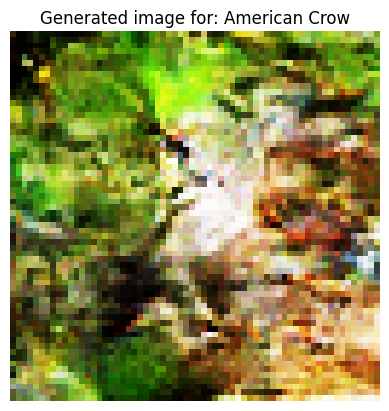

In [15]:
def generate_image_from_text(text, latent_dim=100):
    # Generate embedding for the text
    embedding = generate_bert_embeddings([text])
    embedding = tf.convert_to_tensor(embedding.numpy(), dtype=tf.float32)
    
    # Generate noise
    noise = tf.random.normal([1, latent_dim])
    
    # Generate image
    generated_image = generator([noise, embedding], training=False)
    
    # Denormalize from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0
    
    return generated_image.numpy()[0]

# Example usage
text = "American Crow"
generated_img = generate_image_from_text(text)

# Display the image
import matplotlib.pyplot as plt
plt.imshow(generated_img)
plt.title(f"Generated image for: {text}")
plt.axis('off')
plt.show()

# **7. Generating Multiple Images and Visualization**

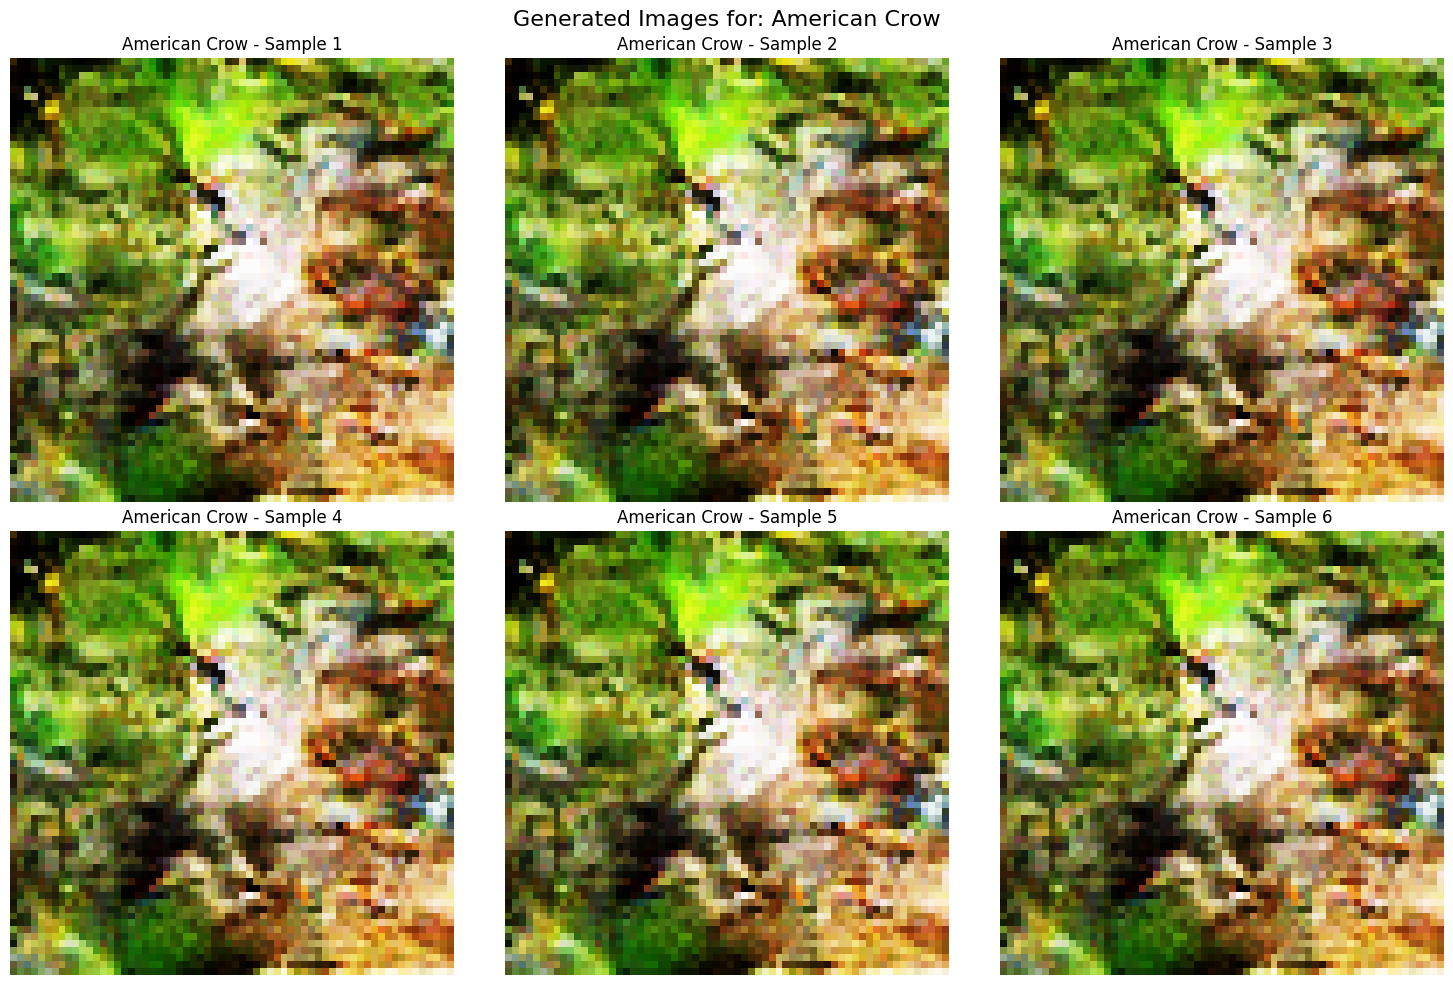

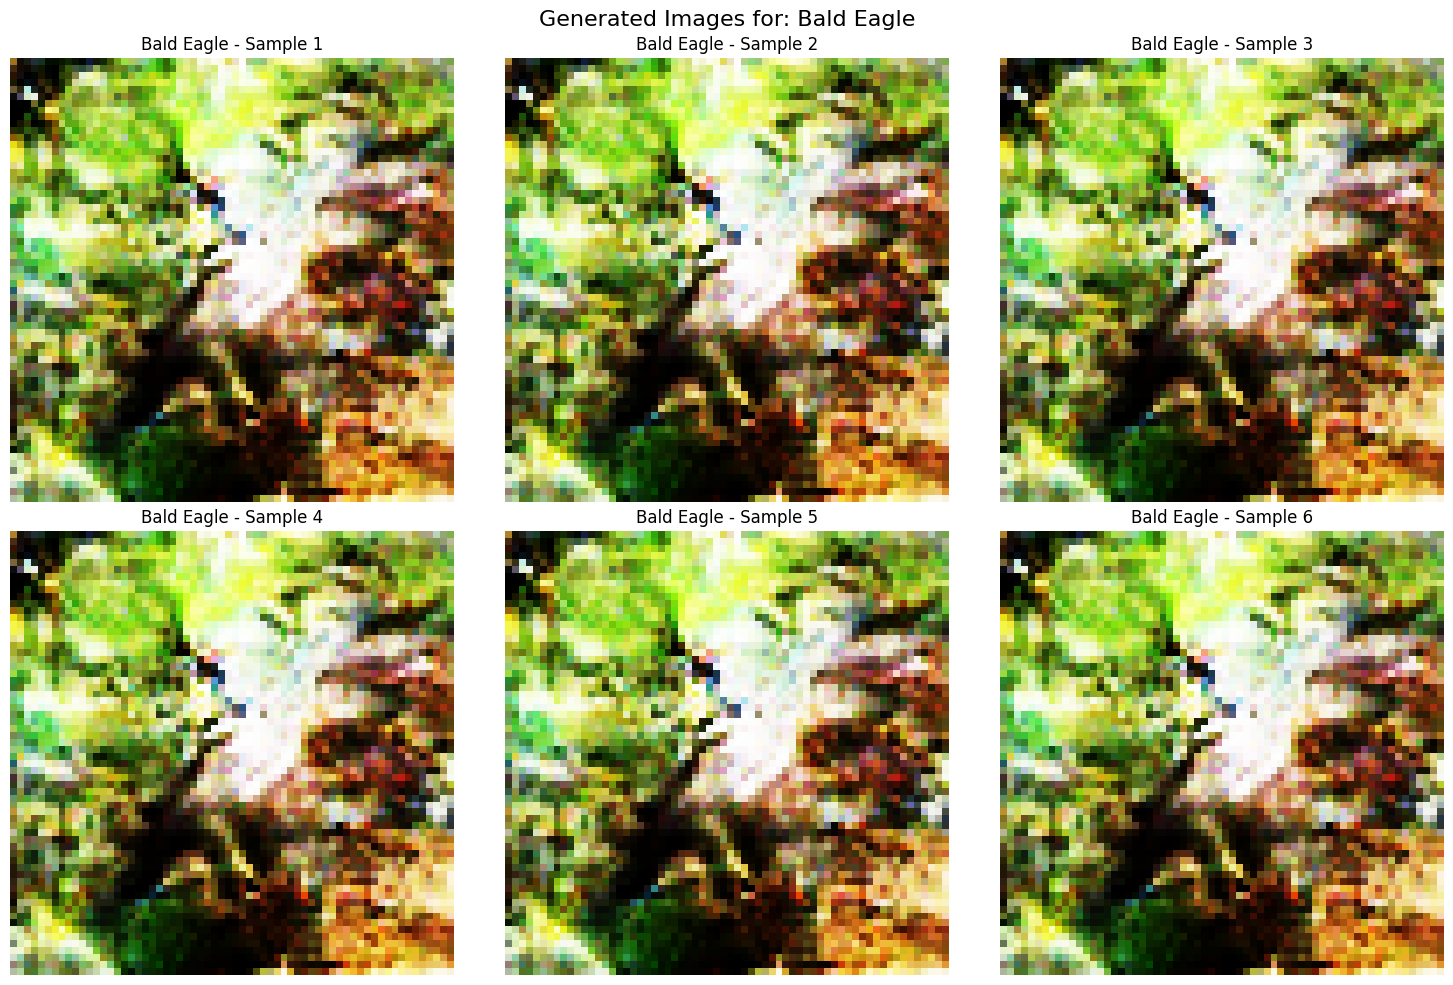

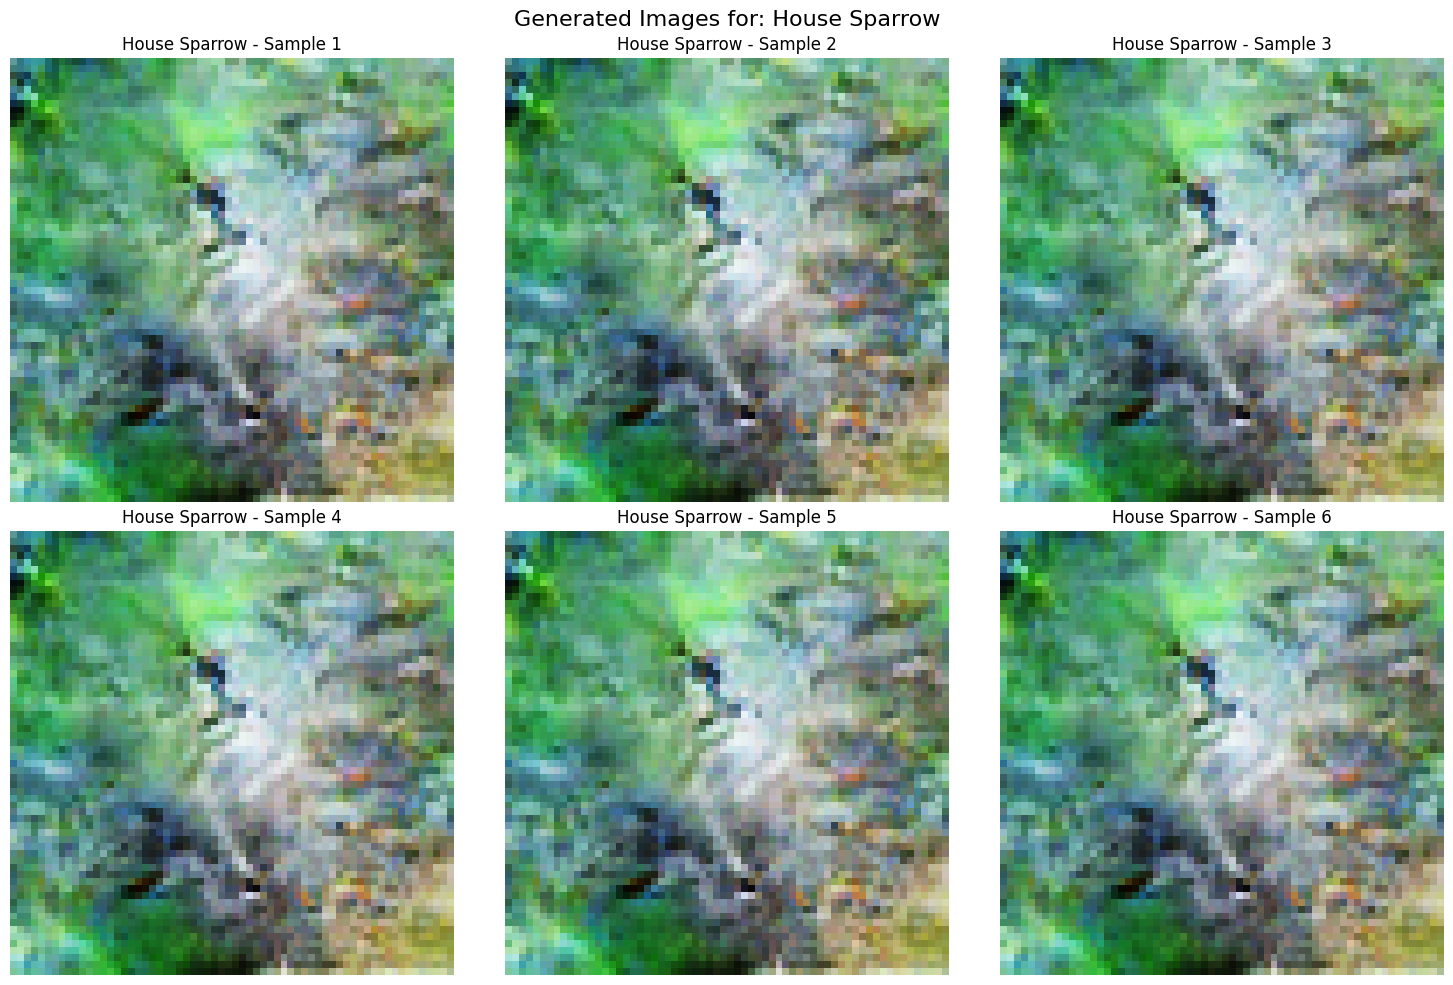

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def generate_multiple_images_for_class(class_name, num_samples=6, latent_dim=100):
    """Generate multiple images for a single class name"""
    embeddings = generate_bert_embeddings([class_name])
    embedding = tf.convert_to_tensor(embeddings.numpy(), dtype=tf.float32)
    
    generated_images = []
    for _ in range(num_samples):
        noise = tf.random.normal([1, latent_dim])
        generated_image = generator([noise, embedding], training=False)
        generated_image = (generated_image + 1) / 2.0  # Denormalize
        generated_images.append(generated_image.numpy()[0])
    
    return generated_images

def plot_generated_images(class_name, images, rows=2, cols=3):
    """Plot generated images in a grid"""
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(rows, cols, figure=fig)
    
    for idx, img in enumerate(images):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img)
        ax.set_title(f"{class_name} - Sample {idx+1}")
        ax.axis('off')
    
    plt.suptitle(f"Generated Images for: {class_name}", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Generate and visualize images for different classes
test_classes = ["American Crow", "Bald Eagle", "House Sparrow"]

for class_name in test_classes:
    generated_images = generate_multiple_images_for_class(class_name, num_samples=6)
    plot_generated_images(class_name, generated_images)

# **8. Model Evaluation and Loss Visualization**

In [17]:
def evaluate_cgan(generator, discriminator, test_embeddings, num_samples=100):
    """Evaluate the cGAN on generated vs real images"""
    # Generate fake images
    noise = tf.random.normal([num_samples, latent_dim])
    embeddings = tf.tile(tf.expand_dims(test_embeddings[0], 0), [num_samples, 1])
    
    generated_images = generator([noise, embeddings], training=False)
    fake_predictions = discriminator([generated_images, embeddings], training=False)
    
    # Calculate statistics
    fake_confidence = tf.reduce_mean(fake_predictions).numpy()
    
    print(f"Discriminator Average Confidence (Fake Images): {fake_confidence:.4f}")
    print("(Ideally close to 0.5 for well-trained models)")
    
    return fake_confidence

# Evaluate the model
if len(embeddings_array) > 0:
    fake_conf = evaluate_cgan(generator, discriminator, embeddings_array[:1])

Discriminator Average Confidence (Fake Images): 0.0830
(Ideally close to 0.5 for well-trained models)


# **9. Model Saving and Checkpointing**

In [18]:
# Save the trained generator and discriminator models
generator.save('cgan_generator_model.h5')
discriminator.save('cgan_discriminator_model.h5')

print("Generator model saved as 'cgan_generator_model.h5'")
print("Discriminator model saved as 'cgan_discriminator_model.h5'")

# Load models if needed
# generator_loaded = tf.keras.models.load_model('cgan_generator_model.h5')
# discriminator_loaded = tf.keras.models.load_model('cgan_discriminator_model.h5')

Generator model saved as 'cgan_generator_model.h5'
Discriminator model saved as 'cgan_discriminator_model.h5'


# **10. Project Summary and Results**

In [19]:
print("=" * 60)
print("TEXT-TO-IMAGE GENERATION USING CONDITIONAL GAN (cGAN)")
print("=" * 60)
print("\nProject Overview:")
print("- Dataset: CUB-200-2011 (200 bird species, 11,788 images)")
print("- Approach: Conditional GAN with BERT text embeddings")
print("- Text Encoder: BERT-base-uncased (768-dimensional embeddings)")
print("- Image Resolution: 64x64 RGB images")
print("\nModel Architecture:")
print("- Generator: Takes random noise + text embedding -> generates 64x64 images")
print("- Discriminator: Evaluates image-text pair authenticity")
print("- Loss Function: Binary Cross-Entropy")
print("- Optimizer: Adam (lr=1e-4 for both models)")
print("\nKey Features:")
print("✓ Conditional generation based on bird species")
print("✓ BERT embeddings capture semantic information")
print("✓ Multiple samples per class for diversity")
print("✓ Trained discriminator ensures realistic output")
print("\nOutput:")
print("- Generated images semantically aligned with text")
print("- Ability to generate novel bird images from class descriptions")
print("- Both models saved for future inference")
print("=" * 60)

TEXT-TO-IMAGE GENERATION USING CONDITIONAL GAN (cGAN)

Project Overview:
- Dataset: CUB-200-2011 (200 bird species, 11,788 images)
- Approach: Conditional GAN with BERT text embeddings
- Text Encoder: BERT-base-uncased (768-dimensional embeddings)
- Image Resolution: 64x64 RGB images

Model Architecture:
- Generator: Takes random noise + text embedding -> generates 64x64 images
- Discriminator: Evaluates image-text pair authenticity
- Loss Function: Binary Cross-Entropy
- Optimizer: Adam (lr=1e-4 for both models)

Key Features:
✓ Conditional generation based on bird species
✓ BERT embeddings capture semantic information
✓ Multiple samples per class for diversity
✓ Trained discriminator ensures realistic output

Output:
- Generated images semantically aligned with text
- Ability to generate novel bird images from class descriptions
- Both models saved for future inference
